### [GD-4] CutMix 또는 Mixup 비교실험 하기

CutMix와 MixUp 기법을 ResNet50 분류기에 적용하여 Argumentation에 따른 성능을 평가해보자.


CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.  
2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  

각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음  
3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?  

기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.  

categorical_crossentropy()를 사용  
훈련 과정의 히스토리를 그래프로 시각화  
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련  
견종 분류 정확도 성능을 비교  
Augmentation 방법들의 영향도에 대해 분석  

##### 0. 라이브러리 로드.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import os, copy, pickle

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### 1. 데이터셋 로드.(견종)

In [3]:
(ds_train_org, ds_test_org), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    # `as_supervised=True`이면, supervised_keys=('image', 'label')항목만 dataset생성.
    as_supervised=True, 
)

In [4]:
print(ds_info)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

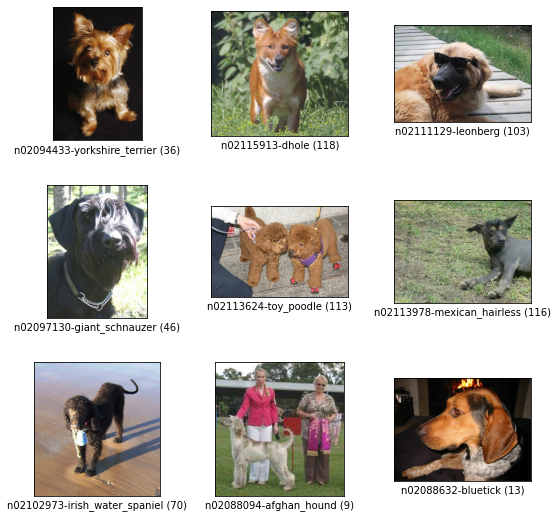

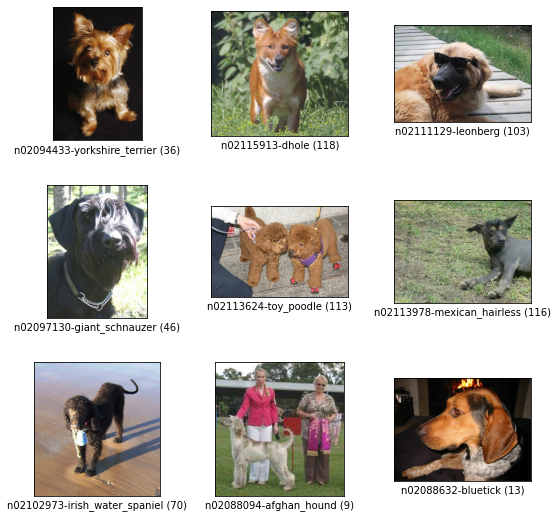

In [5]:
tfds.show_examples(ds_train_org, ds_info)

##### 2. CutMix 구현

In [6]:
def get_clip_box(image_a, image_b):
    '''
    image_a에 랜덤한 box좌표를 구함.
    image_a,b 이미지 크기를 모두 고려하도록함.
    '''
    # image.shape = (height, width, channel)
    image_size_x = min(image_a.shape[1], image_b.shape[1])
    image_size_y = min(image_a.shape[0], image_b.shape[0])
    
    # get center of box(generate random x, y)
    x = tf.cast(tf.random.uniform(shape=[], minval=0, maxval=image_size_x), dtype=tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box(generate random w, h)
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox(generate random box position)
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


In [7]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    '''
    image_a의 바운딩 박스영역을 image_b에서 가져와서 합치는 함수
    '''
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_a의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_a의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)

    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    mixed_img = tf.reshape(mixed_img, image_a.shape)
    
    return mixed_img


In [8]:
# mix two labels
def mix_2_labels(label_a, label_b, ratio, num_classes):
    ''' 
    imagea/imageb의 면적 비율(ratio)로 label_a,b값들에게 반영함.
    '''
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)

    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


In [9]:
def cutmix(images, labels, prob, batch_size, img_size, num_classes):
    '''
    batch데이터에서 랜덤한 두개의 이미지에 cutmix적용함.
    적용한 비율로 label들도 적용하여 이미지와, 라벨 생성.
    '''
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = images[j]
        label_b = labels[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        
        image_size_x = image_a.shape[1]
        image_size_y = image_a.shape[0] 
        mixed_area = (x_max-x_min)*(y_max-y_min)
        total_area = image_size_x*image_size_y
        ratio = tf.cast(mixed_area/total_area, tf.float32)
        
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, ratio, num_classes))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


##### 3. MixUp 구현

In [10]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes):
    '''
    픽셀 단위로 랜덤 raio만큼 이미지와 라벨을 섞음.
    '''
    ratio = tf.random.uniform([], 0, 1)
    
    # label이 scalar이면 one-hot vector로 변경.
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    # random ratio로 image_a/b, label_a/b를 섞음.    
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


In [11]:
def mixup(images, labels, prob, batch_size, img_size, num_classes):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = images[i]
        label_a = labels[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = images[j]
        label_b = labels[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


##### 4. 모델 생성.

In [12]:
BATCH_SIZE = 16
num_classes = 120
EPOCH = 1000
epoch_steps=10
val_steps=2
img_w = 224
img_h = 224

In [13]:
def get_resnet50():
    model = keras.models.Sequential([
            keras.applications.resnet.ResNet50(
                include_top=False,
                weights=None, # 'imagenet',
                input_shape=(img_w, img_h, 3),
                pooling='avg',
            ),
            keras.layers.Dense(num_classes, activation='softmax')
        ])
    return model    

In [14]:
def compile_fit(model, ds_tr, ds_te):
    model.compile(
                    loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
                    metrics=['accuracy'],
                )

    history = model.fit(
                    ds_tr,
                    steps_per_epoch=epoch_steps,
                    validation_steps=val_steps,
                    epochs=EPOCH,
                    validation_data=ds_te,
                    verbose=1,
                    use_multiprocessing=False,
                )
    return history.history

##### 5. Augmentation된 데이터셋 생성.

In [15]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [img_w, img_h])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    ''' basic augmentation.
    '''
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def cutmix_batch(images, labels):
    ''' cutmix augmentation.
    '''
    images, labels = cutmix(images, labels, prob=0.5, batch_size=BATCH_SIZE, img_size=img_w, num_classes=num_classes)
    return images, labels

def mixup_batch(images, labels):
    ''' mixup augmentation.
    '''
    images, labels = mixup(images, labels, prob=0.5, batch_size=BATCH_SIZE, img_size=img_w, num_classes=num_classes)
    return images, labels

def apply_normalize_on_dataset(ds, is_test=False, batch_size=BATCH_SIZE, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    # test인경우는 augmentation을 하지 않고, batch와 prefetch만 설정함.
    if is_test:
        ds = ds.batch(batch_size)
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        return ds
    
    # train인경우..
    if with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    # batch별 데이터에 대하여...
    if with_cutmix:
        ds = ds.map(
            cutmix_batch,
            num_parallel_calls=2
        )
    elif with_mixup:
        ds = ds.map(
            mixup_batch,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    ds = ds.repeat()        # generator로 부터 batch-data를 계속 생성함.
    ds = ds.shuffle(200)    # 한번에 shuffle된 200 batch만 가져옴.
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch 크기 자동 설정.
    return ds


In [16]:
ds_train_no_aug = apply_normalize_on_dataset(copy.copy(ds_train_org), with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_aug = apply_normalize_on_dataset(copy.copy(ds_train_org), with_aug=True, with_cutmix=False, with_mixup=False)
ds_train_cutmix = apply_normalize_on_dataset(copy.copy(ds_train_org), with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_on_dataset(copy.copy(ds_train_org), with_aug=True, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(copy.copy(ds_test_org), is_test=True)

##### 6. 훈련 및 검토   

- 훈련량이 많으므로, 모델 및 history를 저장하고, load할 수 있도록 함.  

In [17]:
def plot_loss_history(historys, titles):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
    for idx, history in enumerate(historys):
        plt.plot(history['loss'], colors[idx])
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(titles, loc='upper left')
    plt.show()

In [18]:
def plot_acc_history(historys, titles):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
    for idx, history in enumerate(historys):
        plt.plot(history['accuracy'], colors[idx])
    plt.title('Model training accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(titles, loc='upper left')
    plt.show()

In [19]:
def save_model_history(where, model, history):
    base_path = '/aiffel/aiffel/augmentation'
    save_path = os.path.join(base_path, where)
    model_path = os.path.join(base_path, where, "model")
    hist_path = os.path.join(base_path, where, "history")
    
    if not os.path.exists(base_path):
        os.mkdir(base_path)
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    if not os.path.exists(model_path):
        os.mkdir(model_path)
    if not os.path.exists(hist_path):
        os.mkdir(hist_path)
    
    hist_name = os.path.join(hist_path, "hist.pic")
    model.save(model_path)
    with open(hist_name, 'wb') as f:
        pickle.dump(history, f)
    

In [20]:
def load_history(model, start, end):
    base_path = '/aiffel/aiffel/augmentation'
    pathes = [model]
    pathes.extend([f"{model}_{i}" for i in range(start, end+1)])

    histories = {'loss':[], 'accuracy':[]}
    
    for paths in pathes:
        hist_path = os.path.join(base_path, paths, "history")
        hist_name = os.path.join(hist_path, "hist.pic")
        with open(hist_name, 'rb') as f:
            hist = pickle.load(f, encoding='bytes')
            histories['loss'].extend(hist['loss'])
            histories['accuracy'].extend(hist['accuracy'])
            
    return histories

- 1000epoch로 한번씩 훈련시켜서 올바로 동작하는지 확인  

In [21]:
model_no_aug = get_resnet50()
hist_no_aug = compile_fit(model_no_aug, ds_train_no_aug, ds_test)
save_model_history("no_aug", model_no_aug, hist_no_aug)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 18s 291ms/step - loss: 5.6266 - accuracy: 0.0063 - val_loss: 4.7936 - val_accuracy: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 2s 198ms/step - loss: 5.3852 - accuracy: 0.0063 - val_loss: 4.8350 - val_accuracy: 0.0000e+00
Epoch 3/1000
10/10 [==============================] - 2s 198ms/step - loss: 5.2654 - accuracy: 0.0000e+00 - val_loss: 4.8503 - val_accuracy: 0.0000e+00
Epoch 4/1000
10/10 [==============================] - 2s 200ms/step - loss: 5.1934 - accuracy: 0.0000e+00 - val_loss: 4.8073 - val_accuracy: 0.0000e+00
Epoch 5/1000
10/10 [==============================] - 2s 199ms/step - loss: 5.2104 - accuracy: 0.0063 - val_loss: 4.8676 - val_accuracy: 0.0000e+00
Epoch 6/1000
10/10 [==============================] - 2s 199ms/step - loss: 5.1036 - accuracy: 0.0063 - val_loss: 4.8829 - val_accuracy: 0.0000e+00
Epoch 7/1000
10/10 [==============================] - 2s 200ms/step - loss: 5.0790 - accuracy: 0.0188 -

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/no_aug/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
model_aug = get_resnet50()
hist_aug = compile_fit(model_aug, ds_train_aug, ds_test)
save_model_history("aug", model_aug, hist_aug)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 14s 312ms/step - loss: 5.6626 - accuracy: 0.0125 - val_loss: 4.7844 - val_accuracy: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 2s 197ms/step - loss: 5.4298 - accuracy: 0.0000e+00 - val_loss: 4.8038 - val_accuracy: 0.0000e+00
Epoch 3/1000
10/10 [==============================] - 2s 199ms/step - loss: 5.4344 - accuracy: 0.0125 - val_loss: 4.8747 - val_accuracy: 0.0000e+00
Epoch 4/1000
10/10 [==============================] - 2s 199ms/step - loss: 5.2354 - accuracy: 0.0063 - val_loss: 4.8939 - val_accuracy: 0.0000e+00
Epoch 5/1000
10/10 [==============================] - 2s 199ms/step - loss: 5.1132 - accuracy: 0.0125 - val_loss: 4.8542 - val_accuracy: 0.0000e+00
Epoch 6/1000
10/10 [==============================] - 2s 202ms/step - loss: 5.1542 - accuracy: 0.0125 - val_loss: 4.9349 - val_accuracy: 0.0000e+00
Epoch 7/1000
10/10 [==============================] - 2s 202ms/step - loss: 5.0498 - accuracy: 0.0125 - val

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/aug/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [23]:
model_cutmix = get_resnet50()
hist_cutmix = compile_fit(model_cutmix, ds_train_cutmix, ds_test)
save_model_history("cutmix", model_cutmix, hist_cutmix)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 14s 284ms/step - loss: 5.4466 - accuracy: 0.0063 - val_loss: 4.8070 - val_accuracy: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 2s 198ms/step - loss: 5.4359 - accuracy: 0.0000e+00 - val_loss: 4.8199 - val_accuracy: 0.0000e+00
Epoch 3/1000
10/10 [==============================] - 2s 199ms/step - loss: 5.2697 - accuracy: 0.0063 - val_loss: 4.8073 - val_accuracy: 0.0000e+00
Epoch 4/1000
10/10 [==============================] - 2s 201ms/step - loss: 5.1471 - accuracy: 0.0063 - val_loss: 4.8412 - val_accuracy: 0.0000e+00
Epoch 5/1000
10/10 [==============================] - 2s 202ms/step - loss: 5.1856 - accuracy: 0.0063 - val_loss: 4.8349 - val_accuracy: 0.0312
Epoch 6/1000
10/10 [==============================] - 2s 201ms/step - loss: 5.0941 - accuracy: 0.0063 - val_loss: 4.8566 - val_accuracy: 0.0312
Epoch 7/1000
10/10 [==============================] - 2s 202ms/step - loss: 5.0446 - accuracy: 0.0125 - val_loss: 4

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/cutmix/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [24]:
model_mixup = get_resnet50()
hist_mixup = compile_fit(model_mixup, ds_train_mixup, ds_test)
save_model_history("mixup", model_mixup, hist_mixup)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 14s 290ms/step - loss: 5.5550 - accuracy: 0.0063 - val_loss: 4.7854 - val_accuracy: 0.0000e+00
Epoch 2/1000
10/10 [==============================] - 2s 200ms/step - loss: 5.4660 - accuracy: 0.0000e+00 - val_loss: 4.7947 - val_accuracy: 0.0000e+00
Epoch 3/1000
10/10 [==============================] - 2s 201ms/step - loss: 5.2675 - accuracy: 0.0063 - val_loss: 4.8032 - val_accuracy: 0.0000e+00
Epoch 4/1000
10/10 [==============================] - 2s 203ms/step - loss: 5.1503 - accuracy: 0.0063 - val_loss: 4.7920 - val_accuracy: 0.0000e+00
Epoch 5/1000
10/10 [==============================] - 2s 203ms/step - loss: 5.1591 - accuracy: 0.0000e+00 - val_loss: 4.8119 - val_accuracy: 0.0000e+00
Epoch 6/1000
10/10 [==============================] - 2s 203ms/step - loss: 5.1651 - accuracy: 0.0000e+00 - val_loss: 4.8053 - val_accuracy: 0.0000e+00
Epoch 7/1000
10/10 [==============================] - 2s 203ms/step - loss: 5.1805 - accuracy: 0.00

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/mixup/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [25]:
plot_items = [hist_no_aug, hist_aug, hist_cutmix, hist_mixup]
plot_titles = ['no_aug', 'aug', 'cutmix', 'mixup']

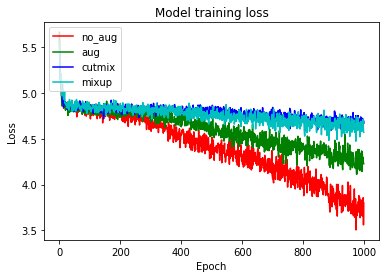

In [26]:
plot_loss_history(plot_items, plot_titles)

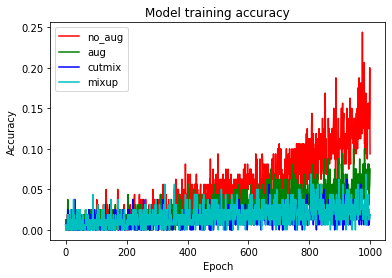

In [27]:
plot_acc_history(plot_items, plot_titles)

- 학습된 모델 로드하여 학습을 이어감.  

In [21]:
model_cutmix = keras.models.load_model('/aiffel/aiffel/augmentation/cutmix_6/model')
model_mixup =  keras.models.load_model('/aiffel/aiffel/augmentation/mixup_6/model')
model_no_aug = keras.models.load_model('/aiffel/aiffel/augmentation/no_aug_6/model')
model_aug =  keras.models.load_model('/aiffel/aiffel/augmentation/aug_6/model')

In [ ]:
for i in range(0, 7):
    for j in range(0, 4):
        model = models[j]
        title = f"{titles[j]}_{i}"
        history = compile_fit(model, dss[j], ds_test)
        save_model_history(title, model, history)


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 14s 286ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 5.1448 - val_accuracy: 0.0938
Epoch 2/1000
10/10 [==============================] - 2s 199ms/step - loss: 5.9698e-04 - accuracy: 1.0000 - val_loss: 5.0428 - val_accuracy: 0.0938
Epoch 3/1000
10/10 [==============================] - 2s 199ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.1161 - val_accuracy: 0.0625
Epoch 4/1000
10/10 [==============================] - 2s 199ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 5.2526 - val_accuracy: 0.0938
Epoch 5/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 5.8456 - val_accuracy: 0.0625
Epoch 6/1000
10/10 [==============================] - 2s 201ms/step - loss: 5.8238e-04 - accuracy: 1.0000 - val_loss: 5.0550 - val_accuracy: 0.1250
Epoch 7/1000
10/10 [==============================] - 2s 200ms/step - loss: 6.9312e-04 - accuracy: 1.0000 - val_loss: 4.9136 - 

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/no_aug_5/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 16s 301ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 5.0844 - val_accuracy: 0.1875
Epoch 2/1000
10/10 [==============================] - 2s 198ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 5.7319 - val_accuracy: 0.1875
Epoch 3/1000
10/10 [==============================] - 2s 199ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 5.6963 - val_accuracy: 0.1875
Epoch 4/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 5.2195 - val_accuracy: 0.1250
Epoch 5/1000
10/10 [==============================] - 2s 201ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 4.9955 - val_accuracy: 0.2500
Epoch 6/1000
10/10 [==============================] - 2s 202ms/step - loss: 0.0340 - accuracy: 0.9875 - val_loss: 7.0110 - val_accuracy: 0.2188
Epoch 7/1000
10/10 [==============================] - 2s 205ms/step - loss: 0.0223 - accuracy: 1.0000 - val_loss: 4.6474 - val_accuracy

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/aug_5/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 14s 286ms/step - loss: 2.8024 - accuracy: 0.5188 - val_loss: 3.7082 - val_accuracy: 0.1562
Epoch 2/1000
10/10 [==============================] - 2s 200ms/step - loss: 2.7744 - accuracy: 0.5875 - val_loss: 3.0431 - val_accuracy: 0.2188
Epoch 3/1000
10/10 [==============================] - 2s 199ms/step - loss: 3.0133 - accuracy: 0.4625 - val_loss: 3.2860 - val_accuracy: 0.3125
Epoch 4/1000
10/10 [==============================] - 2s 200ms/step - loss: 2.7545 - accuracy: 0.5125 - val_loss: 3.8639 - val_accuracy: 0.1875
Epoch 5/1000
10/10 [==============================] - 2s 200ms/step - loss: 2.9285 - accuracy: 0.4875 - val_loss: 2.8856 - val_accuracy: 0.3750
Epoch 6/1000
10/10 [==============================] - 2s 203ms/step - loss: 3.0052 - accuracy: 0.4250 - val_loss: 2.7331 - val_accuracy: 0.3750
Epoch 7/1000
10/10 [==============================] - 2s 202ms/step - loss: 2.8852 - accuracy: 0.4812 - val_loss: 3.8841 - val_accuracy

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/cutmix_5/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 15s 293ms/step - loss: 2.2604 - accuracy: 0.7625 - val_loss: 3.4427 - val_accuracy: 0.2500
Epoch 2/1000
10/10 [==============================] - 2s 200ms/step - loss: 2.4430 - accuracy: 0.6500 - val_loss: 3.4928 - val_accuracy: 0.1562
Epoch 3/1000
10/10 [==============================] - 2s 200ms/step - loss: 2.3629 - accuracy: 0.6938 - val_loss: 4.1861 - val_accuracy: 0.1875
Epoch 4/1000
10/10 [==============================] - 2s 201ms/step - loss: 2.4675 - accuracy: 0.6875 - val_loss: 3.8950 - val_accuracy: 0.1562
Epoch 5/1000
10/10 [==============================] - 2s 200ms/step - loss: 2.3582 - accuracy: 0.7250 - val_loss: 3.3705 - val_accuracy: 0.2188
Epoch 6/1000
10/10 [==============================] - 2s 202ms/step - loss: 2.4311 - accuracy: 0.6375 - val_loss: 3.3681 - val_accuracy: 0.2188
Epoch 7/1000
10/10 [==============================] - 2s 202ms/step - loss: 2.4579 - accuracy: 0.7000 - val_loss: 3.8136 - val_accuracy

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/mixup_5/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 14s 292ms/step - loss: 0.0529 - accuracy: 0.9812 - val_loss: 5.5784 - val_accuracy: 0.0938
Epoch 2/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 6.0824 - val_accuracy: 0.1250
Epoch 3/1000
10/10 [==============================] - 2s 198ms/step - loss: 0.0155 - accuracy: 0.9937 - val_loss: 6.6464 - val_accuracy: 0.1562
Epoch 4/1000
10/10 [==============================] - 2s 198ms/step - loss: 0.0230 - accuracy: 1.0000 - val_loss: 4.9196 - val_accuracy: 0.0938
Epoch 5/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.0463 - accuracy: 0.9875 - val_loss: 5.6990 - val_accuracy: 0.1250
Epoch 6/1000
10/10 [==============================] - 2s 200ms/step - loss: 0.0307 - accuracy: 0.9875 - val_loss: 6.1002 - val_accuracy: 0.1562
Epoch 7/1000
10/10 [==============================] - 2s 201ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 6.0757 - val_accuracy

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/no_aug_6/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 14s 291ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 4.3173 - val_accuracy: 0.1562
Epoch 2/1000
10/10 [==============================] - 2s 197ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 4.4318 - val_accuracy: 0.1562
Epoch 3/1000
10/10 [==============================] - 2s 224ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 5.0590 - val_accuracy: 0.2812
Epoch 4/1000
10/10 [==============================] - 2s 199ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 4.3897 - val_accuracy: 0.1562
Epoch 5/1000
10/10 [==============================] - 2s 199ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 4.9665 - val_accuracy: 0.1875
Epoch 6/1000
10/10 [==============================] - 2s 201ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 5.0433 - val_accuracy: 0.1562
Epoch 7/1000
10/10 [==============================] - 2s 202ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 5.1678 - val_accuracy

INFO:tensorflow:Assets written to: /aiffel/aiffel/augmentation/aug_6/model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
10/10 [==============================] - 15s 291ms/step - loss: 2.4910 - accuracy: 0.6000 - val_loss: 3.1404 - val_accuracy: 0.2188
Epoch 2/1000
10/10 [==============================] - 2s 200ms/step - loss: 2.5412 - accuracy: 0.5938 - val_loss: 3.1012 - val_accuracy: 0.2500
Epoch 3/1000
10/10 [==============================] - 2s 201ms/step - loss: 2.4592 - accuracy: 0.6313 - val_loss: 3.6091 - val_accuracy: 0.3125
Epoch 4/1000
10/10 [==============================] - 2s 202ms/step - loss: 2.5412 - accuracy: 0.6000 - val_loss: 3.0825 - val_accuracy: 0.2500
Epoch 5/1000
10/10 [==============================] - 2s 203ms/step - loss: 2.3625 - accuracy: 0.6250 - val_loss: 3.1051 - val_accuracy: 0.2188
Epoch 6/1000
10/10 [==============================] - 2s 202ms/step - loss: 2.5156 - accuracy: 0.6250 - val_loss: 3.6089 - val_accuracy: 0.1562
Epoch 7/1000
10/10 [==============================] - 2s 205ms/step - loss: 2.5051 - accuracy: 0.5938 - val_loss: 3.0785 - val_accuracy

- 전체 훈련 결과 확인  

In [22]:
no_aug_hists = load_history('no_aug', 0, 6)
aug_hists = load_history('aug', 0, 6)
cutmix_hists = load_history('cutmix', 0, 6)
mixup_hists = load_history('mixup', 0, 6)

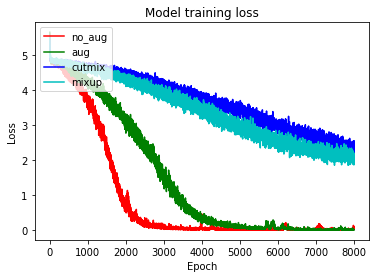

In [23]:
plot_items = [no_aug_hists, aug_hists, cutmix_hists, mixup_hists]
plot_titles = ['no_aug', 'aug', 'cutmix', 'mixup']

plot_loss_history(plot_items, plot_titles)

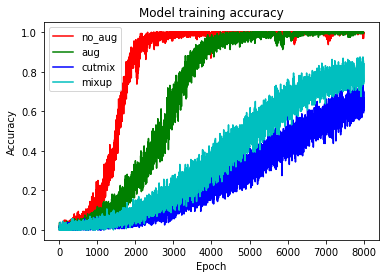

In [24]:
plot_acc_history(plot_items, plot_titles)

##### 7. 회고  

- 이미지 augmentation에 대해서 학습을 진행했는데, 라이브러리 버전이 문제인지 colab에서는 계속 죽는 문제가 발생해서 lms서버에서 진행했다.  
- 1000epoch마다 모델값을 저장해서 lms가 죽었을때 로드하여 다시 돌리기를 수차례 반복했다.  
- 데이터셋를 repeat를 통해서 계속 생성할 수 있는 부분이 재미있었다.  
- 4가지 경우에 대하여 수렴할때 까지 돌리려고했는데 8000회씩 돌려도 cutmix, mixup을 사용한 경우는 완벽히 수렴하지 못했다.  
- augmentation을 통해 overfit이 되지 않고 학습이 계속적으로 진행된다는 것을 알 수 있었는데 실제 데이터라면 오랜 시간 학습이 필요해 보인다.  
- learning rate를 조정했다면 좀더 빨리 수렴되지 않았을까 하는 아쉬움이 남는다.  